In [144]:
import sys
sys.path.append("/home/alexander/Work/Repos/")
from batchflow.models.tf import DeepGalerkin
from batchflow import Pipeline, Dataset, DatasetIndex, Batch, B, L, F, V
from batchflow import NumpySampler as NS
import numpy as np
import matplotlib.pyplot as plt
import batchflow
from tqdm import tqdm_notebook
from ipywidgets import interact

In [145]:
import tensorflow as tf

### Configuring `DeepGalerkin` model for solving PDE
$$f(x, t): \quad \frac{\partial f}{\partial t} - \frac{\partial^2 f}{\partial x^2} = Q_{well}(x),
$$
$$f(x, 0)=-(x - 0.8)^2 + 0.64,$$
$$f(0, t) = 0,\quad f(1, t) = 0.6.
$$

* Training points are from uniform distribution on **[0, 1]**, as the equation is solved on that domain.

In [245]:
st = NS('u') & NS('e', scale=1).truncate(high=5) # uniform over [0, 1] and exponential over [0, T]

* configuring the well

In [246]:
r_well = 0.1
center_well = 0.5
q_mult = 5

* setting up `config` for `DeepGalerkin`-model

In [247]:
layout = 'faRf+faRfaf+af'
initial_condition = lambda x: -(x[0] - 0.8)**2 + 0.64

form_lhs = {'d1': (0, 1),
            'd2': ((-1, 0), (0, 0))}
Q_rhs = lambda t: 0.5 * q_mult * (tf.sign(r_well**2 - tf.square(t[:, :1] - center_well)) + 1)
T = 5
domain=[[0, 1], [0, T]]

config = {
    'inputs': dict(points={'shape': (2, )}),
    'initial_block/inputs': 'points',
    'body': dict(layout=layout,
                 units=[10, 10, 25, 30, 25, 1],
                 activation=[tf.nn.tanh, tf.nn.tanh, tf.nn.tanh, tf.nn.tanh]),
    'common': dict(form=form_lhs,
                   bind_bc_ic=True,
                   initial_condition=initial_condition,
                   Q=Q_rhs,
                   domain=domain,
                   time_multiplier='sigmoid'),
    'loss': 'mse'}

Note:
* `f` in `layout=[fafaf]` stands for a **f**ully-connected layer
* `a` in `layout=[fafaf]` stands for **a**ctivation-function

So, coupled with `activation=[tf.nn.tanh, tf.nn.tanh]` and `units=[10, 15, 1]`, `layout='fafaf'` sets up a fully-connected network with 2 hidden layers (with 10 and 15 units) and `tanh`-activations.

Note also:
* `form={'d1':(0, 1), 'd2':((-1, 0), (0, 0))}` sets up the left-hand-side of the equation as $$\frac{\partial f}{\partial t} - \frac{\partial^2 f}{\partial x^2}=\dots$$

* `Q_rhs = lambda t: 0.5 * q_mult * (tf.sign(r_well**2 - tf.square(t[:, :1] - center_well)) + 1)` says that the right-hand side of the equation is given by
$$\dots = q_{mult}  \mathcal{I}\left[x \in B_{0.1}(0.5)\right]$$
* `initial_condition = lambda x: -(x[0] - 0.8)**2 + 0.64` states that initial condition is given by
$$ f(x, 0)=-(x - 0.8)^2 + 0.64.$$

### Preparing training `pipeline` 

In [235]:
pipeline = (Pipeline()
            .init_variable('loss', default=[])
            .init_variable('dt', default=[])
            .init_model('static', DeepGalerkin, 'DG', config)
            .train_model('DG',
                         feed_dict={'points': L(st.sample, size=F(len))},
                         fetches='loss',
                         save_to=V('loss'), mode='a'))

In [236]:
dsix = DatasetIndex(np.arange(100))
pipeline_ds = Dataset(dsix) >> pipeline

### Running 3000-iters of network-training

In [237]:
dg = pipeline_ds.get_model_by_name('DG')

In [238]:
for i in tqdm_notebook(range(5000)):
    pipeline_ds.next_batch(300, n_epochs=None)

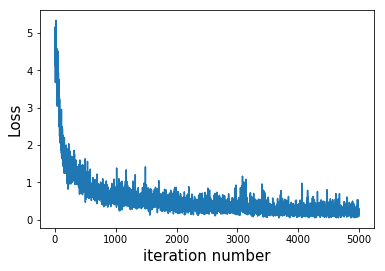

In [239]:
plt.plot(pipeline_ds.get_variable('loss')[:])
plt.xlabel('iteration number', fontdict={'fontsize': 15})
plt.ylabel('Loss',fontdict={'fontsize': 15})
pass

### Plot the network solution

In [240]:
tsteps = np.linspace(0, 3, 1000)
grid = np.linspace(0, 1, 50).reshape(-1, 1)
approxs = [dg.session.run(dg.approximator, feed_dict={dg.points:
                                                      np.concatenate([grid, t * np.ones_like(grid)], axis=1)}) for
          t in tsteps]

preds = [dg.session.run(dg.predictions, feed_dict={dg.points:
                                                   np.concatenate([grid, t * np.ones_like(grid)], axis=1)}) for
          t in tsteps]

In [243]:
def inter_plot(i):
    plt.plot(grid, approxs[i], label='Network approximation')
    plt.xlabel(r'$t$', fontdict={'fontsize': 14})
    plt.ylim(0, 1)
    plt.legend()

In [244]:
interact(lambda i: inter_plot(i),
         i=(0, 999, 1))

interactive(children=(IntSlider(value=499, description='i', max=999), Output()), _dom_classes=('widget-interac…

<function __main__.<lambda>(i)>